### PACE_L3_basicplot

This notebook is for basic Level 3 plots. 

It uses the Earthaccess and Xarray libraries for data search. This means it is intended for provisional and standard products available on Earthdata search. All relevant information is intended to be specified in the "Identify and search product, specify plotting parameters" cell. 

If multiple images are found a gif animation is created

Results are plotted to the screen and saved as a .png file. 

NOTE:
 - Currently only works for 2D data products. 3D implementation to be specified

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import re
from sklearn.neighbors import KDTree
from PIL import Image
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import PillowWriter

### Earthdata Authentication
We authenticate using our Earthdata Login credentials. Authentication is not needed to search publicly available collections in Earthdata, but is always needed to access data. We can use the login method from the earthaccess package. This will create an authenticated session when we provide a valid Earthdata Login username and password. The earthaccess package will search for credentials defined by environmental variables or within a .netrc file saved in the home directory. If credentials are not found, an interactive prompt will allow you to input credentials.

In [2]:
in_the_cloud = False # set to true if running in cloud (e.g. Cryocloud), false if running locally. For speed, granules will be downloaded to a local_data directory when set to false
auth = earthaccess.login(persist=True)

### If desired, print all available PACE Level 3 short names

In [3]:
if False:
    results_oci = earthaccess.search_datasets(instrument="oci",processing_level_id='3')
    results_harp = earthaccess.search_datasets(instrument="harp2",processing_level_id='3')
    results_spex = earthaccess.search_datasets(instrument="spexone",processing_level_id='3')
    results=results_oci + results_harp + results_spex
    for item in results:
        summary = item.summary()
        print(summary["short-name"])

### Identify and search product, specify plotting parameters

In [4]:
#Case for NW_smoke_transport_20250902
if True:
    tspan = ("2025-09-02", "2025-09-07")
    bbox = (-140., 30., -60., 60.0)
    granule_name = "*.Day.*0p1deg*",  # Daily, 8-day or monthly: Day, 8D or MO | Resolution: 0p1deg or 0.4km
    TAG = 'Northwest fires: PACE OCI smoke aerosol index'
    short_name = "PACE_OCI_L3M_AER_UAA_NRT"
    variable_name = 'NUV_AerosolIndex'
    plot_range = (0,5)
    colormap = 'hot_r'
    local_path = '~/Documents/data/PACE/rapid_response/smoke/'
    this_dir = 'NW_smoke_transport_20250902/'

In [5]:
#Case for SEAtlantic_smoke_transport_202508_202509
if False:
    tspan = ("2025-08-01", "2025-09-09")
    bbox = (-35., -30., 20., 10.0)
    granule_name = "*.Day.*0p1deg*",  # Daily, 8-day or monthly: Day, 8D or MO | Resolution: 0p1deg or 0.4km
    TAG = 'SE Atlantic smoke: PACE OCI smoke aerosol index'
    short_name = "PACE_OCI_L3M_AER_UAA_NRT"
    variable_name = 'NUV_AerosolIndex'
    plot_range = (0,5)
    colormap = 'hot_r'
    local_path = '~/Documents/data/PACE/rapid_response/smoke/'
    this_dir = 'SEAtlantic_smoke_transport_202508_202509/'

In [6]:
outdir = local_path + this_dir
outdir = os.path.expanduser(outdir)  # This converts ~ to full home path


results = earthaccess.search_data(
    short_name=short_name,
    temporal=tspan,
    granule_name=granule_name
)
print('Number of granules: ',len(results))

Number of granules:  6


In [7]:
if in_the_cloud == True:
    paths = earthaccess.open(results, local_path="data")
else:
    paths = earthaccess.download(results, local_path = outdir)
    print('Files Downloaded')

#paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

Files Downloaded


### Open and read file(s)

In [8]:
def read_l3_files(file_paths, variable_name, bbox=None):
    """
    Read Level 3 files and combine them
    
    Parameters:
        file_paths: list of file paths from earthaccess.download() or earthaccess.open()
        variable_name: name of the variable to extract
        bbox: tuple of (lon_min, lat_min, lon_max, lat_max) for subsetting
    
    Returns:
        combined_ds: xarray Dataset with the variable and coordinates
    """
    
    print(f"Reading {len(file_paths)} L3 files...")
    
    datasets = []
    
    for i, file_path in enumerate(file_paths):
        print()
        try:
            print(f"Processing file {i+1}/{len(file_paths)}")
            
            # Extract date from filename
            filename = os.path.basename(str(file_path))
            print(f"  Filename: {filename}")
            
            # Extract date from PACE L3 filename pattern: PACE_OCI.YYYYMMDD.L3m...
            date_match = re.search(r'PACE_OCI\.(\d{8})\.', filename)
            if date_match:
                date_str = date_match.group(1)
                filename_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
                #print(f"  Extracted date: {filename_date}")
            else:
                print(f"  Warning: Could not extract date from filename")
                # Fallback: try any 8-digit pattern
                date_match = re.search(r'(\d{8})', filename)
                if date_match:
                    date_str = date_match.group(1)
                    filename_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
                    #print(f"  Extracted date (fallback): {filename_date}")
                else:
                    print(f"  Could not extract date, skipping file")
                    continue
            
            # Read the L3 file - try different approaches for downloaded files
            ds = None
            
            # First, let's explore what's in the file
            try:
                # Try to open at root level first
                print(f"  Attempting to open file at root level...")
                ds_root = xr.open_dataset(file_path)
                #print(f"  Root level variables: {list(ds_root.variables.keys())}")
                #print(f"  Root level data variables: {list(ds_root.data_vars.keys())}")
                
                if variable_name in ds_root.variables:
                    ds = ds_root
                    print(f"  Found '{variable_name}' at root level")
                else:
                    ds_root.close()  # Close if we're not using it
                    
            except Exception as e:
                print(f"  Could not open at root level: {e}")
            
            # If not found at root, try different groups
            if ds is None:
                for group in ['geophysical_data', 'science_data']:
                    try:
                        print(f"  Attempting to open '{group}' group...")
                        ds_group = xr.open_dataset(file_path, group=group)
                        #print(f"  {group} variables: {list(ds_group.variables.keys())}")
                        #print(f"  {group} data variables: {list(ds_group.data_vars.keys())}")
                        
                        if variable_name in ds_group.variables:
                            ds = ds_group
                            print(f"  Found '{variable_name}' in {group} group")
                            break
                        else:
                            ds_group.close()
                            
                    except Exception as e:
                        print(f"  Could not open {group} group: {e}")
                        continue
            
            # If still not found, let's see what variables ARE available
            if ds is None:
                print(f"  Could not find variable '{variable_name}' in any location")
                print(f"  Let's see what variables are available...")
                
                # Try to list all available variables in the file
                try:
                    with xr.open_dataset(file_path) as temp_ds:
                        print(f"  Available variables at root: {list(temp_ds.variables.keys())}")
                        
                    # Try to check groups using h5py or netCDF4
                    try:
                        import h5py
                        with h5py.File(file_path, 'r') as f:
                            print(f"  HDF5 groups: {list(f.keys())}")
                            for group_name in f.keys():
                                if isinstance(f[group_name], h5py.Group):
                                    print(f"    {group_name} variables: {list(f[group_name].keys())}")
                    except:
                        try:
                            import netCDF4 as nc
                            with nc.Dataset(file_path, 'r') as f:
                                print(f"  NetCDF groups: {list(f.groups.keys())}")
                                print(f"  NetCDF variables: {list(f.variables.keys())}")
                                for group_name in f.groups.keys():
                                    print(f"    {group_name} variables: {list(f.groups[group_name].variables.keys())}")
                        except:
                            pass
                            
                except Exception as e:
                    print(f"  Error exploring file structure: {e}")
                
                continue
            
            # Create correct time coordinate from filename
            correct_time = np.datetime64(filename_date)
            
            # Add or replace time coordinate
            if 'time' in ds.dims:
                # Replace existing time coordinate
                ds = ds.assign_coords(time=[correct_time])
            else:
                # Add time dimension if it doesn't exist
                ds = ds.expand_dims('time')
                ds = ds.assign_coords(time=[correct_time])
            
            print(f"  Set time coordinate to: {correct_time}")
            
            # Get coordinate information
            # L3 files usually have lat/lon as 1D coordinate arrays
            lat_coord = None
            for lat_name in ['lat', 'latitude', 'Latitude', 'LAT']:
                if lat_name in ds.coords:
                    lat_coord = lat_name
                    print(f"  Found latitude coordinate: {lat_name}")
                    break
            
            lon_coord = None        
            for lon_name in ['lon', 'longitude', 'Longitude', 'LON']:
                if lon_name in ds.coords:
                    lon_coord = lon_name
                    print(f"  Found longitude coordinate: {lon_name}")
                    break
            
            if lat_coord is None:
                print(f"  Could not find latitude coordinate in file {i+1}")
                print(f"  Available coordinates: {list(ds.coords.keys())}")
                continue
                
            if lon_coord is None:
                print(f"  Could not find longitude coordinate in file {i+1}")
                print(f"  Available coordinates: {list(ds.coords.keys())}")
                continue
            
            # Subset by bounding box if provided
            if bbox is not None:
                lon_min, lat_min, lon_max, lat_max = bbox
                
                # Select data within bounding box
                ds_subset = ds.sel(
                    {lon_coord: slice(lon_min, lon_max),
                     lat_coord: slice(lat_min, lat_max)}
                )
                
                print(f"  Subset to bbox: {ds_subset[variable_name].shape}")
            else:
                ds_subset = ds
            
            # Standardize coordinate names
            if lat_coord != 'latitude':
                ds_subset = ds_subset.rename({lat_coord: 'latitude'})
            if lon_coord != 'longitude':
                ds_subset = ds_subset.rename({lon_coord: 'longitude'})
            
            datasets.append(ds_subset)
            
        except Exception as e:
            print(f"Error reading file {i+1}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if not datasets:
        print("No datasets successfully loaded!")
        return None
    
    print(f"Successfully loaded {len(datasets)} datasets")
    
    # Sort datasets by time before combining (in case files were not in order)
    datasets.sort(key=lambda x: x.time.values[0])
    
    # Combine datasets along time dimension if multiple files
    if len(datasets) == 1:
        combined_ds = datasets[0]
    else:
        try:
            # Concatenate along time dimension
            combined_ds = xr.concat(datasets, dim='time')
            print("Combined datasets along time dimension")
        except:
            try:
                # If concatenation fails, try to merge
                combined_ds = xr.merge(datasets)
                print("Merged datasets")
            except Exception as e:
                print(f"Could not combine datasets: {e}")
                print("Using first dataset only")
                combined_ds = datasets[0]
    
    # Print final time coordinate information
    if 'time' in combined_ds.coords:
        print(f"Final time coordinates:")
        for i, time_val in enumerate(combined_ds.time.values):
            print(f"  {i}: {time_val}")
    
    # Print info about the combined dataset
    print(f"Final dataset shape for '{variable_name}': {combined_ds[variable_name].shape}")
    print(f"Coordinate ranges:")
    print(f"  Longitude: {combined_ds.longitude.min().values:.2f} to {combined_ds.longitude.max().values:.2f}")
    print(f"  Latitude: {combined_ds.latitude.min().values:.2f} to {combined_ds.latitude.max().values:.2f}")
    
    return combined_ds

In [9]:
dataset = read_l3_files(paths, variable_name)

Reading 6 L3 files...

Processing file 1/6
  Filename: PACE_OCI.20250902.L3m.DAY.AER_UAA.V3_1.0p1deg.NRT.nc
  Attempting to open file at root level...
  Found 'NUV_AerosolIndex' at root level
  Set time coordinate to: 2025-09-02
  Found latitude coordinate: lat
  Found longitude coordinate: lon

Processing file 2/6
  Filename: PACE_OCI.20250903.L3m.DAY.AER_UAA.V3_1.0p1deg.NRT.nc
  Attempting to open file at root level...
  Found 'NUV_AerosolIndex' at root level
  Set time coordinate to: 2025-09-03
  Found latitude coordinate: lat
  Found longitude coordinate: lon

Processing file 3/6
  Filename: PACE_OCI.20250904.L3m.DAY.AER_UAA.V3_1.0p1deg.NRT.nc
  Attempting to open file at root level...
  Found 'NUV_AerosolIndex' at root level
  Set time coordinate to: 2025-09-04
  Found latitude coordinate: lat
  Found longitude coordinate: lon

Processing file 4/6
  Filename: PACE_OCI.20250905.L3m.DAY.AER_UAA.V3_1.0p1deg.NRT.nc
  Attempting to open file at root level...
  Found 'NUV_AerosolIndex' 

### Plot results

In [10]:
def plot_pace_l3_data_daily(dataset, variable_name, plot_range=None, colormap='viridis', 
                           outdir='.', title_tag='PACE L3', bbox=None, 
                           percentile_range=(2, 98), nan_color='black',
                           ncols=None, figsize_per_plot=(6, 5)):
    """
    Plot Level 3 data with separate subplot for each day
    
    Parameters:
        dataset: xarray Dataset from read_pace_l3_files()
        variable_name: name of variable to plot
        plot_range: tuple of (vmin, vmax) or None for auto-range
        colormap: matplotlib colormap name
        outdir: output directory
        title_tag: tag for plot title
        bbox: tuple of (lon_min, lat_min, lon_max, lat_max) for plot extent only
        percentile_range: percentiles for auto-ranging
        nan_color: color for NaN values
        ncols: number of columns for subplot grid (auto-calculated if None)
        figsize_per_plot: size of each individual subplot
    """
    
    if dataset is None or variable_name not in dataset.variables:
        print("No data to plot!")
        return None, None
    
    # Get the data variable
    data_var = dataset[variable_name]
    
    print(f"Original data shape: {data_var.shape}")
    
    # Check if time dimension exists
    if 'time' not in data_var.dims:
        print("No time dimension found - creating single plot")
        return plot_pace_l3_data_single(dataset, variable_name, plot_range, colormap, 
                                       outdir, title_tag, bbox, percentile_range, nan_color)
    
    # Get number of time steps
    n_times = len(data_var.time)
    print(f"Found {n_times} time steps")
    
    if n_times == 1:
        print("Only one time step - creating single plot")
        return plot_pace_l3_data_single(dataset, variable_name, plot_range, colormap, 
                                       outdir, title_tag, bbox, percentile_range, nan_color)
    
    # Calculate subplot grid dimensions
    if ncols is None:
        ncols = min(4, n_times)  # Max 4 columns
    nrows = int(np.ceil(n_times / ncols))
    
    print(f"Creating {nrows}x{ncols} subplot grid")
    
    # Calculate figure size
    fig_width = ncols * figsize_per_plot[0]
    fig_height = nrows * figsize_per_plot[1]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Subset data for plotting if bbox is specified
    if bbox is not None:
        lon_min, lat_min, lon_max, lat_max = bbox
        print(f"Subsetting data to bbox: lon {lon_min} to {lon_max}, lat {lat_min} to {lat_max}")
        
        try:
            lons = dataset.longitude.values
            lats = dataset.latitude.values
            
            if lon_max < lon_min:  # bbox crosses dateline
                lon_mask = (lons >= lon_min) | (lons <= lon_max)
            else:
                lon_mask = (lons >= lon_min) & (lons <= lon_max)
            
            lat_mask = (lats >= lat_min) & (lats <= lat_max)
            
            if np.sum(lon_mask) == 0 or np.sum(lat_mask) == 0:
                print("Warning: No data points within specified bbox, using full dataset")
                plot_extent = None
                plot_data = data_var
            else:
                plot_data = data_var.sel(
                    longitude=data_var.longitude[lon_mask],
                    latitude=data_var.latitude[lat_mask]
                )
                plot_extent = [lon_min, lon_max, lat_min, lat_max]
                
        except Exception as e:
            print(f"Error during subsetting: {e}")
            plot_extent = None
            plot_data = data_var
    else:
        plot_data = data_var
        lon_min, lon_max = float(dataset.longitude.min()), float(dataset.longitude.max())
        lat_min, lat_max = float(dataset.latitude.min()), float(dataset.latitude.max())
        plot_extent = [lon_min, lon_max, lat_min, lat_max]
    
    # Calculate plot range using all time steps
    if plot_range is None:
        valid_data = plot_data.values[~np.isnan(plot_data.values)]
        if len(valid_data) == 0:
            print("Warning: No valid data found!")
            vmin, vmax = 0, 1
        else:
            vmin = np.percentile(valid_data, percentile_range[0])
            vmax = np.percentile(valid_data, percentile_range[1])
            print(f"Auto-calculated range for all days: {vmin:.3f} to {vmax:.3f}")
    else:
        vmin, vmax = plot_range
        print(f"Using specified range: {vmin} to {vmax}")
    
    # Create colormap
    base_cmap = plt.colormaps.get_cmap(colormap)
    cmap_with_nan = base_cmap.copy()
    
    # Handle NaN colors for cartopy
    if nan_color.lower() in ['black', 'k']:
        nan_facecolor = 'black'
        cmap_with_nan.set_bad(alpha=0)
    elif nan_color.lower() in ['transparent', 'none']:
        nan_facecolor = 'white'
        cmap_with_nan.set_bad(alpha=0)
    else:
        nan_facecolor = nan_color
        cmap_with_nan.set_bad(alpha=0)
    
    # Create subplots for each day
    axes = []
    ims = []
    
    for i in range(n_times):
        # Create subplot
        ax = fig.add_subplot(nrows, ncols, i+1, projection=ccrs.PlateCarree())
        axes.append(ax)
        
        # Set background color for NaN values
        ax.set_facecolor(nan_facecolor)
        
        # Add map features with BLACK boundaries and land
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
        ax.add_feature(cfeature.LAND, color='black', alpha=0.3)  # Black land
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        
        # Set extent
        if plot_extent is not None:
            ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
        
        # Get data for this time step
        day_data = plot_data.isel(time=i)
        
        # Plot the data
        im = ax.pcolormesh(
            day_data.longitude, 
            day_data.latitude, 
            day_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap_with_nan,
            vmin=vmin,
            vmax=vmax,
            shading='auto'
        )
        ims.append(im)
        
        # Format date for title
        time_val = plot_data.time.values[i]
        try:
            # Handle different time formats
            if hasattr(time_val, 'strftime'):
                date_str = time_val.strftime('%Y-%m-%d')
            elif hasattr(time_val, 'astype'):
                # Handle numpy datetime64
                date_str = str(time_val.astype('datetime64[D]'))
            else:
                date_str = str(time_val)[:10]
        except:
            date_str = str(time_val)[:10]
        
        # Set title with date
        ax.set_title(f'{title_tag}\n{date_str}', fontsize=10, pad=10)
        
        # Add gridlines for larger subplots
        if figsize_per_plot[0] >= 6:
            gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 8}
            gl.ylabel_style = {'size': 8}
    
    # Add a single colorbar for all subplots
    # Position colorbar on the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label(variable_name, fontsize=12)
    
    # Add main title with date range
    time_range = f"{str(plot_data.time.values[0])[:10]} to {str(plot_data.time.values[-1])[:10]}"
    fig.suptitle(f'{title_tag} - Daily Views\n{time_range}', fontsize=16, y=0.95)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.9, top=0.88)  # Make room for colorbar and title
    
    # Generate filename
    if bbox:
        bbox_str = f"{bbox[0]:.0f}_{bbox[1]:.0f}_{bbox[2]:.0f}_{bbox[3]:.0f}"
        region_tag = "subset"
    else:
        bbox_str = "global" 
        region_tag = "global"
    
    start_date = str(plot_data.time.values[0])[:10].replace('-', '')
    end_date = str(plot_data.time.values[-1])[:10].replace('-', '')
    filename = f"PACE_L3_{variable_name}_daily_{start_date}_{end_date}_{region_tag}_{bbox_str}.png"
    
    save_path = os.path.join(outdir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Daily subplot plot saved to: {save_path}")
    
    plt.show()
    
    return fig, axes



In [11]:
def plot_pace_l3_data_single(dataset, variable_name, plot_range=None, colormap='viridis', 
                            outdir='.', title_tag='PACE L3', bbox=None, 
                            percentile_range=(2, 98), nan_color='black'):
    """Single plot version with black boundaries and date in title"""
    
    if dataset is None or variable_name not in dataset.variables:
        print("No data to plot!")
        return None, None
    
    data_var = dataset[variable_name]
    
    # Handle time dimension if present
    if 'time' in data_var.dims:
        if len(data_var.time) == 1:
            plot_data = data_var.isel(time=0)
            time_val = data_var.time.values[0]
        else:
            plot_data = data_var.mean(dim='time')
            time_val = data_var.time.values[0]  # Use first date for title
    else:
        plot_data = data_var
        time_val = None
    
    # Format date for title
    if time_val is not None:
        try:
            if hasattr(time_val, 'strftime'):
                date_str = time_val.strftime('%Y-%m-%d')
            elif hasattr(time_val, 'astype'):
                date_str = str(time_val.astype('datetime64[D]'))
            else:
                date_str = str(time_val)[:10]
        except:
            date_str = str(time_val)[:10]
    else:
        date_str = "Unknown date"
    
    # Subset data for plotting if bbox is specified
    if bbox is not None:
        lon_min, lat_min, lon_max, lat_max = bbox
        try:
            lons = dataset.longitude.values
            lats = dataset.latitude.values
            
            if lon_max < lon_min:
                lon_mask = (lons >= lon_min) | (lons <= lon_max)
            else:
                lon_mask = (lons >= lon_min) & (lons <= lon_max)
            
            lat_mask = (lats >= lat_min) & (lats <= lat_max)
            
            if np.sum(lon_mask) == 0 or np.sum(lat_mask) == 0:
                plot_extent = None
            else:
                plot_data = plot_data.sel(
                    longitude=plot_data.longitude[lon_mask],
                    latitude=plot_data.latitude[lat_mask]
                )
                plot_extent = [lon_min, lon_max, lat_min, lat_max]
        except:
            plot_extent = None
    else:
        lon_min, lon_max = float(dataset.longitude.min()), float(dataset.longitude.max())
        lat_min, lat_max = float(dataset.latitude.min()), float(dataset.latitude.max())
        plot_extent = [lon_min, lon_max, lat_min, lat_max]
    
    # Calculate plot range
    if plot_range is None:
        valid_data = plot_data.values[~np.isnan(plot_data.values)]
        if len(valid_data) == 0:
            vmin, vmax = 0, 1
        else:
            vmin = np.percentile(valid_data, percentile_range[0])
            vmax = np.percentile(valid_data, percentile_range[1])
    else:
        vmin, vmax = plot_range
    
    # Create the plot
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Handle NaN colors
    base_cmap = plt.colormaps.get_cmap(colormap)
    cmap_with_nan = base_cmap.copy()
    
    if nan_color.lower() in ['black', 'k']:
        ax.set_facecolor('black')
        cmap_with_nan.set_bad(alpha=0)
    elif nan_color.lower() in ['transparent', 'none']:
        ax.set_facecolor('white')
        cmap_with_nan.set_bad(alpha=0)
    else:
        ax.set_facecolor(nan_color)
        cmap_with_nan.set_bad(alpha=0)
    
    # Add map features with BLACK boundaries and land
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    ax.add_feature(cfeature.LAND, color='lightbrown', alpha=0.3)  
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Set extent
    if plot_extent is not None:
        ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
    
    # Plot the data
    im = ax.pcolormesh(
        plot_data.longitude, 
        plot_data.latitude, 
        plot_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap_with_nan,
        vmin=vmin,
        vmax=vmax,
        shading='auto'
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
    cbar.set_label(variable_name, fontsize=12)
    
    # Add title with date
    plt.title(f'{title_tag}\n{date_str}', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.tight_layout()
    
    # Generate filename
    if bbox:
        bbox_str = f"{bbox[0]:.0f}_{bbox[1]:.0f}_{bbox[2]:.0f}_{bbox[3]:.0f}"
        region_tag = "subset"
    else:
        bbox_str = "global"
        region_tag = "global"
    
    date_str_clean = date_str.replace('-', '')
    filename = f"PACE_L3_{variable_name}_{date_str_clean}_{region_tag}_{bbox_str}.png"
    
    save_path = os.path.join(outdir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, ax

In [12]:
def create_l3_mp4(dataset, variable_name, plot_range=None, colormap='viridis', 
                  outdir='.', title_tag='PACE L3', bbox=None, 
                  percentile_range=(2, 98), nan_color='black',
                  figsize=(12, 8), fps=1, dpi=150, bitrate=1800):
    """
    Create an animated MP4 of PACE Level 3 data cycling through each day
    
    Parameters:
        dataset: xarray Dataset from read_l3_files()
        variable_name: name of variable to plot
        plot_range: tuple of (vmin, vmax) or None for auto-range
        colormap: matplotlib colormap name
        outdir: output directory
        title_tag: tag for plot title
        bbox: tuple of (lon_min, lat_min, lon_max, lat_max) for plot extent only
        percentile_range: percentiles for auto-ranging
        nan_color: color for NaN values
        figsize: figure size (width, height)
        fps: frames per second for the video
        dpi: resolution for the video frames
        bitrate: video bitrate in kbps
    
    Returns:
        filename of saved MP4
    """
    
    if dataset is None or variable_name not in dataset.variables:
        print("No data to animate!")
        return None
    
    # Get the data variable
    data_var = dataset[variable_name]
    
    print(f"Original data shape: {data_var.shape}")
    
    # Check if time dimension exists
    if 'time' not in data_var.dims:
        print("No time dimension found - cannot create animation")
        return None
    
    # Get number of time steps
    n_times = len(data_var.time)
    print(f"Found {n_times} time steps for animation")
    
    if n_times == 1:
        print("Only one time step - cannot create animation")
        return None
    
    # Subset data for plotting if bbox is specified
    if bbox is not None:
        lon_min, lat_min, lon_max, lat_max = bbox
        print(f"Applying bbox constraint: lon {lon_min} to {lon_max}, lat {lat_min} to {lat_max}")
        
        try:
            lons = dataset.longitude.values
            lats = dataset.latitude.values
            
            if lon_max < lon_min:  # bbox crosses dateline
                lon_mask = (lons >= lon_min) | (lons <= lon_max)
            else:
                lon_mask = (lons >= lon_min) & (lons <= lon_max)
            
            lat_mask = (lats >= lat_min) & (lats <= lat_max)
            
            if np.sum(lon_mask) == 0 or np.sum(lat_mask) == 0:
                print("Warning: No data points within specified bbox, using full dataset")
                plot_extent = [lon_min, lon_max, lat_min, lat_max]
                plot_data = data_var
            else:
                plot_data = data_var.sel(
                    longitude=data_var.longitude[lon_mask],
                    latitude=data_var.latitude[lat_mask]
                )
                plot_extent = [lon_min, lon_max, lat_min, lat_max]
                print(f"Data subset to shape: {plot_data.shape}")
                
        except Exception as e:
            print(f"Error during subsetting: {e}, using full dataset")
            plot_extent = [lon_min, lon_max, lat_min, lat_max]
            plot_data = data_var
    else:
        plot_data = data_var
        lon_min, lon_max = float(dataset.longitude.min()), float(dataset.longitude.max())
        lat_min, lat_max = float(dataset.latitude.min()), float(dataset.latitude.max())
        plot_extent = [lon_min, lon_max, lat_min, lat_max]
        print("Using full dataset extent")
    
    # Calculate plot range using the (possibly subsetted) data
    if plot_range is None:
        valid_data = plot_data.values[~np.isnan(plot_data.values)]
        if len(valid_data) == 0:
            print("Warning: No valid data found!")
            vmin, vmax = 0, 1
        else:
            vmin = np.percentile(valid_data, percentile_range[0])
            vmax = np.percentile(valid_data, percentile_range[1])
            actual_min = np.min(valid_data)
            actual_max = np.max(valid_data)
            print(f"Data range: {actual_min:.4f} to {actual_max:.4f}")
            print(f"Auto-calculated plot range ({percentile_range[0]}-{percentile_range[1]}%): {vmin:.3f} to {vmax:.3f}")
    else:
        vmin, vmax = plot_range
        print(f"Using specified plot range: {vmin} to {vmax}")
    
    # Create colormap with NaN handling
    print(f"Using colormap: {colormap}")
    base_cmap = plt.colormaps.get_cmap(colormap)
    cmap_with_nan = base_cmap.copy()
    
    # Handle NaN colors for cartopy
    if nan_color.lower() in ['black', 'k']:
        nan_facecolor = 'black'
        cmap_with_nan.set_bad(alpha=0)
    elif nan_color.lower() in ['transparent', 'none']:
        nan_facecolor = 'white'
        cmap_with_nan.set_bad(alpha=0)
    else:
        nan_facecolor = nan_color
        cmap_with_nan.set_bad(alpha=0)
    
    print(f"NaN areas will appear as: {nan_facecolor}")
    
    # Create the figure with a fixed layout to avoid colorbar issues
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Create subplot with space for colorbar
    ax = fig.add_axes([0.1, 0.1, 0.75, 0.8], projection=ccrs.PlateCarree())
    cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.8])  # Fixed colorbar position
    
    def animate_frame(frame_num):
        """Animation function called for each frame"""
        
        print(f"  Rendering frame {frame_num+1}/{n_times}")
        
        # Clear only the main axis (not the colorbar axis)
        ax.clear()
        cbar_ax.clear()
        
        # Set background color for NaN values
        ax.set_facecolor(nan_facecolor)
        
        # Add map features with BLACK boundaries and land
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
        ax.add_feature(cfeature.LAND, color='black', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        
        # Set map extent
        ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
        
        # Get data for this time step
        day_data = plot_data.isel(time=frame_num)
        
        # Plot the data
        im = ax.pcolormesh(
            day_data.longitude, 
            day_data.latitude, 
            day_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap_with_nan,
            vmin=vmin,
            vmax=vmax,
            shading='auto'
        )
        
        # Add colorbar to the fixed colorbar axis
        cbar = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
        cbar.set_label(variable_name, fontsize=12)
        
        # Format date for title
        time_val = plot_data.time.values[frame_num]
        try:
            if hasattr(time_val, 'strftime'):
                date_str = time_val.strftime('%Y-%m-%d')
            elif hasattr(time_val, 'astype'):
                date_str = str(time_val.astype('datetime64[D]'))
            else:
                date_str = str(time_val)[:10]
        except:
            date_str = str(time_val)[:10]
        
        # Set title with date
        ax.set_title(f'{title_tag}\n{date_str}', fontsize=14, pad=20)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
        
        return [im]
    
    # Create animation
    print("Creating MP4 animation...")
    
    try:
        import matplotlib.animation as animation
        
        # Create the animation object
        anim = animation.FuncAnimation(
            fig, 
            animate_frame, 
            frames=n_times,
            interval=int(1000/fps),  # Convert fps to milliseconds per frame
            blit=False,  # Don't use blitting with cartopy
            repeat=True
        )
        
        # Generate output filename
        if bbox:
            bbox_str = f"{bbox[0]:.0f}_{bbox[1]:.0f}_{bbox[2]:.0f}_{bbox[3]:.0f}"
            region_tag = "subset"
        else:
            bbox_str = "global"
            region_tag = "global"
        
        start_date = str(plot_data.time.values[0])[:10].replace('-', '')
        end_date = str(plot_data.time.values[-1])[:10].replace('-', '')
        
        # Include colormap and range in filename
        range_str = f"{vmin:.2f}_{vmax:.2f}".replace('.', 'p').replace('-', 'neg')
        mp4_filename = f"PACE_L3_{variable_name}_{colormap}_{range_str}_animation_{start_date}_{end_date}_{region_tag}_{bbox_str}.mp4"
        mp4_path = os.path.join(outdir, mp4_filename)
        
        # Set up the writer with MP4-specific settings
        try:
            from matplotlib.animation import FFMpegWriter
            
            # Configure FFmpeg writer for MP4 with H.264 codec (QuickTime compatible)
            writer = FFMpegWriter(
                fps=fps,
                metadata=dict(
                    title=f'{title_tag} Animation',
                    artist='PACE L3 Data',
                    comment=f'Variable: {variable_name}, Range: {vmin:.3f}-{vmax:.3f}'
                ),
                bitrate=bitrate,
                codec='libx264',  # H.264 codec for better compatibility
                extra_args=['-pix_fmt', 'yuv420p']  # Pixel format for QuickTime compatibility
            )
            
            print(f"Saving MP4 animation to: {mp4_path}")
            print(f"  - FPS: {fps}")
            print(f"  - Bitrate: {bitrate} kbps")
            print(f"  - Codec: H.264 (QuickTime compatible)")
            print(f"  - Resolution: {figsize[0]*dpi:.0f}x{figsize[1]*dpi:.0f}")
            
            # Save the animation
            anim.save(mp4_path, writer=writer)
            
            print(f"MP4 animation saved successfully!")
            print(f"  - Colormap: {colormap}")
            print(f"  - Range: {vmin:.3f} to {vmax:.3f}")
            print(f"  - Extent: {plot_extent}")
            print(f"  - Duration: {n_times/fps:.1f} seconds")
            
            plt.close(fig)
            return mp4_path
            
        except ImportError:
            print("FFMpegWriter not available. Cannot create video.")
            plt.close(fig)
            return None
    
    except ImportError:
        print("matplotlib.animation not available")
        plt.close(fig)
        return None
    
    except Exception as e:
        print(f"Error creating MP4 animation: {e}")
        import traceback
        traceback.print_exc()
        plt.close(fig)
        return None

In [13]:
def create_l3_gif(dataset, variable_name, plot_range=None, colormap='viridis', 
                            outdir='.', title_tag='PACE L3', bbox=None, 
                            percentile_range=(2, 98), nan_color='black',
                            figsize=(12, 8), duration=1000, loop=True):
    """
    Create an animated GIF of PACE Level 3 data cycling through each day
    
    Parameters:
        dataset: xarray Dataset from read_l3_files()
        variable_name: name of variable to plot
        plot_range: tuple of (vmin, vmax) or None for auto-range
        colormap: matplotlib colormap name
        outdir: output directory
        title_tag: tag for plot title
        bbox: tuple of (lon_min, lat_min, lon_max, lat_max) for plot extent only
        percentile_range: percentiles for auto-ranging
        nan_color: color for NaN values
        figsize: figure size (width, height)
        duration: duration per frame in milliseconds
        loop: whether to loop the animation
    
    Returns:
        filename of saved GIF
    """
    
    if dataset is None or variable_name not in dataset.variables:
        print("No data to animate!")
        return None
    
    # Get the data variable
    data_var = dataset[variable_name]
    
    print(f"Original data shape: {data_var.shape}")
    
    # Check if time dimension exists
    if 'time' not in data_var.dims:
        print("No time dimension found - cannot create animation")
        return None
    
    # Get number of time steps
    n_times = len(data_var.time)
    print(f"Found {n_times} time steps for animation")
    
    if n_times == 1:
        print("Only one time step - cannot create animation")
        return None
    
    # Subset data for plotting if bbox is specified
    if bbox is not None:
        lon_min, lat_min, lon_max, lat_max = bbox
        print(f"Applying bbox constraint: lon {lon_min} to {lon_max}, lat {lat_min} to {lat_max}")
        
        try:
            lons = dataset.longitude.values
            lats = dataset.latitude.values
            
            if lon_max < lon_min:  # bbox crosses dateline
                lon_mask = (lons >= lon_min) | (lons <= lon_max)
            else:
                lon_mask = (lons >= lon_min) & (lons <= lon_max)
            
            lat_mask = (lats >= lat_min) & (lats <= lat_max)
            
            if np.sum(lon_mask) == 0 or np.sum(lat_mask) == 0:
                print("Warning: No data points within specified bbox, using full dataset")
                plot_extent = [lon_min, lon_max, lat_min, lat_max]  # Still use bbox for extent
                plot_data = data_var
            else:
                plot_data = data_var.sel(
                    longitude=data_var.longitude[lon_mask],
                    latitude=data_var.latitude[lat_mask]
                )
                plot_extent = [lon_min, lon_max, lat_min, lat_max]
                print(f"Data subset to shape: {plot_data.shape}")
                
        except Exception as e:
            print(f"Error during subsetting: {e}, using full dataset")
            plot_extent = [lon_min, lon_max, lat_min, lat_max]  # Still use bbox for extent
            plot_data = data_var
    else:
        plot_data = data_var
        lon_min, lon_max = float(dataset.longitude.min()), float(dataset.longitude.max())
        lat_min, lat_max = float(dataset.latitude.min()), float(dataset.latitude.max())
        plot_extent = [lon_min, lon_max, lat_min, lat_max]
        print("Using full dataset extent")
    
    # Calculate plot range using the (possibly subsetted) data
    if plot_range is None:
        valid_data = plot_data.values[~np.isnan(plot_data.values)]
        if len(valid_data) == 0:
            print("Warning: No valid data found!")
            vmin, vmax = 0, 1
        else:
            vmin = np.percentile(valid_data, percentile_range[0])
            vmax = np.percentile(valid_data, percentile_range[1])
            actual_min = np.min(valid_data)
            actual_max = np.max(valid_data)
            print(f"Data range: {actual_min:.4f} to {actual_max:.4f}")
            print(f"Auto-calculated plot range ({percentile_range[0]}-{percentile_range[1]}%): {vmin:.3f} to {vmax:.3f}")
    else:
        vmin, vmax = plot_range
        print(f"Using specified plot range: {vmin} to {vmax}")
    
    # Create colormap with NaN handling
    print(f"Using colormap: {colormap}")
    base_cmap = plt.colormaps.get_cmap(colormap)
    cmap_with_nan = base_cmap.copy()
    
    # Handle NaN colors for cartopy
    if nan_color.lower() in ['black', 'k']:
        nan_facecolor = 'black'
        cmap_with_nan.set_bad(alpha=0)
    elif nan_color.lower() in ['transparent', 'none']:
        nan_facecolor = 'white'
        cmap_with_nan.set_bad(alpha=0)
    else:
        nan_facecolor = nan_color
        cmap_with_nan.set_bad(alpha=0)
    
    print(f"NaN areas will appear as: {nan_facecolor}")
    
    # Create the figure (will be reused for each frame)
    fig = plt.figure(figsize=figsize)
    
    # Store temporary files for frames
    temp_files = []
    
    print("Creating animation frames...")
    
    for i in range(n_times):
        print(f"  Creating frame {i+1}/{n_times}")
        
        # Clear the figure
        fig.clear()
        
        # Create subplot with cartopy projection
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        
        # Set background color for NaN values
        ax.set_facecolor(nan_facecolor)
        
        # Add map features with BLACK boundaries and land (as specified)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
        ax.add_feature(cfeature.LAND, color='black', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        
        # Set map extent using bbox
        ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
        
        # Get data for this time step
        day_data = plot_data.isel(time=i)
        
        # Plot the data using specified colormap and range
        im = ax.pcolormesh(
            day_data.longitude, 
            day_data.latitude, 
            day_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap_with_nan,  # Use specified colormap
            vmin=vmin,           # Use specified/calculated range
            vmax=vmax,           # Use specified/calculated range
            shading='auto'
        )
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', 
                           shrink=0.8, pad=0.05)
        cbar.set_label(variable_name, fontsize=12)
        
        # Format date for title
        time_val = plot_data.time.values[i]
        try:
            if hasattr(time_val, 'strftime'):
                date_str = time_val.strftime('%Y-%m-%d')
            elif hasattr(time_val, 'astype'):
                date_str = str(time_val.astype('datetime64[D]'))
            else:
                date_str = str(time_val)[:10]
        except:
            date_str = str(time_val)[:10]
        
        # Set title with date
        plt.title(f'{title_tag}\n{date_str}', fontsize=14, pad=20)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
        
        plt.tight_layout()
        
        # Save frame as temporary image
        temp_filename = f"temp_frame_{i:03d}.png"
        temp_path = os.path.join(outdir, temp_filename)
        plt.savefig(temp_path, dpi=150, bbox_inches='tight', facecolor='white')
        temp_files.append(temp_path)
    
    # Create GIF from frames
    print("Assembling GIF animation...")
    
    try:        
        # Load all frames
        images = []
        for temp_file in temp_files:
            img = Image.open(temp_file)
            images.append(img)
        
        # Generate output filename
        if bbox:
            bbox_str = f"{bbox[0]:.0f}_{bbox[1]:.0f}_{bbox[2]:.0f}_{bbox[3]:.0f}"
            region_tag = "subset"
        else:
            bbox_str = "global"
            region_tag = "global"
        
        start_date = str(plot_data.time.values[0])[:10].replace('-', '')
        end_date = str(plot_data.time.values[-1])[:10].replace('-', '')
        
        # Include colormap and range in filename for clarity
        range_str = f"{vmin:.2f}_{vmax:.2f}".replace('.', 'p').replace('-', 'neg')
        gif_filename = f"PACE_L3_{variable_name}_{colormap}_{range_str}_animation_{start_date}_{end_date}_{region_tag}_{bbox_str}.gif"
        gif_path = os.path.join(outdir, gif_filename)
        
        # Save as GIF
        images[0].save(
            gif_path,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0 if loop else 1,
            optimize=True
        )
        
        print(f"GIF animation saved to: {gif_path}")
        print(f"  - Colormap: {colormap}")
        print(f"  - Range: {vmin:.3f} to {vmax:.3f}")
        print(f"  - Extent: {plot_extent}")
        print(f"  - Duration: {duration}ms per frame")
        
        # Clean up temporary files
        for temp_file in temp_files:
            try:
                os.remove(temp_file)
            except:
                pass
        
        plt.close(fig)
        
        return gif_path
        
    except ImportError:
        print("PIL (Pillow) not installed. Install with: pip install Pillow")
        print("Temporary frame files saved for manual GIF creation:")
        for temp_file in temp_files:
            print(f"  {temp_file}")
        return None
    
    except Exception as e:
        print(f"Error creating GIF: {e}")
        print("Temporary frame files saved:")
        for temp_file in temp_files:
            print(f"  {temp_file}")
        return None

In [14]:
# Create MP4 animation
mpg_path = create_l3_mp4(
    dataset, 
    variable_name,
    plot_range=plot_range,
    colormap=colormap,
    outdir=outdir,
    title_tag=TAG,
    bbox=bbox,
    fps=1,          # 2 frames per second
    dpi=300,        # Higher resolution
    bitrate=3600,    # Higher quality
    figsize=(16, 8) # Large figure
)

Original data shape: (6, 1800, 3600)
Found 6 time steps for animation
Applying bbox constraint: lon -140.0 to -60.0, lat 30.0 to 60.0
Data subset to shape: (6, 300, 800)
Using specified plot range: 0 to 5
Using colormap: hot_r
NaN areas will appear as: black
Creating MP4 animation...
Saving MP4 animation to: /Users/kknobels/Documents/data/PACE/rapid_response/smoke/NW_smoke_transport_20250902/PACE_L3_NUV_AerosolIndex_hot_r_0p00_5p00_animation_20250902_20250907_subset_-140_30_-60_60.mp4
  - FPS: 1
  - Bitrate: 3600 kbps
  - Codec: H.264 (QuickTime compatible)
  - Resolution: 4800x2400
  Rendering frame 1/6
  Rendering frame 1/6
  Rendering frame 2/6
  Rendering frame 3/6
  Rendering frame 4/6
  Rendering frame 5/6
  Rendering frame 6/6
MP4 animation saved successfully!
  - Colormap: hot_r
  - Range: 0.000 to 5.000
  - Extent: [-140.0, -60.0, 30.0, 60.0]
  - Duration: 6.0 seconds


In [15]:
# Slow animation (2 seconds per frame) Fast animation has duration = 500 for 0.5 sec per frame
gif_path = create_l3_gif(
    dataset, 
    variable_name,           # 
    plot_range=plot_range,   # 
    colormap=colormap,       # 
    outdir=outdir,           # 
    title_tag=TAG,           # 
    bbox=bbox,               # 
    duration=1000,           # 0.5 seconds per frame
    figsize=(16, 8)         # Larger figure
)

Original data shape: (6, 1800, 3600)
Found 6 time steps for animation
Applying bbox constraint: lon -140.0 to -60.0, lat 30.0 to 60.0
Data subset to shape: (6, 300, 800)
Using specified plot range: 0 to 5
Using colormap: hot_r
NaN areas will appear as: black
Creating animation frames...
  Creating frame 1/6
  Creating frame 2/6
  Creating frame 3/6
  Creating frame 4/6
  Creating frame 5/6
  Creating frame 6/6
Assembling GIF animation...
GIF animation saved to: /Users/kknobels/Documents/data/PACE/rapid_response/smoke/NW_smoke_transport_20250902/PACE_L3_NUV_AerosolIndex_hot_r_0p00_5p00_animation_20250902_20250907_subset_-140_30_-60_60.gif
  - Colormap: hot_r
  - Range: 0.000 to 5.000
  - Extent: [-140.0, -60.0, 30.0, 60.0]
  - Duration: 1000ms per frame


Original data shape: (6, 1800, 3600)
Found 6 time steps
Creating 3x2 subplot grid
Subsetting data to bbox: lon -140.0 to -60.0, lat 30.0 to 60.0
Using specified range: 0 to 5


/var/folders/gg/qb407cxn73jfl2g4msdk22_40000gp/T/ipykernel_62177/3380362102.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Daily subplot plot saved to: /Users/kknobels/Documents/data/PACE/rapid_response/smoke/NW_smoke_transport_20250902/PACE_L3_NUV_AerosolIndex_daily_20250902_20250907_subset_-140_30_-60_60.png


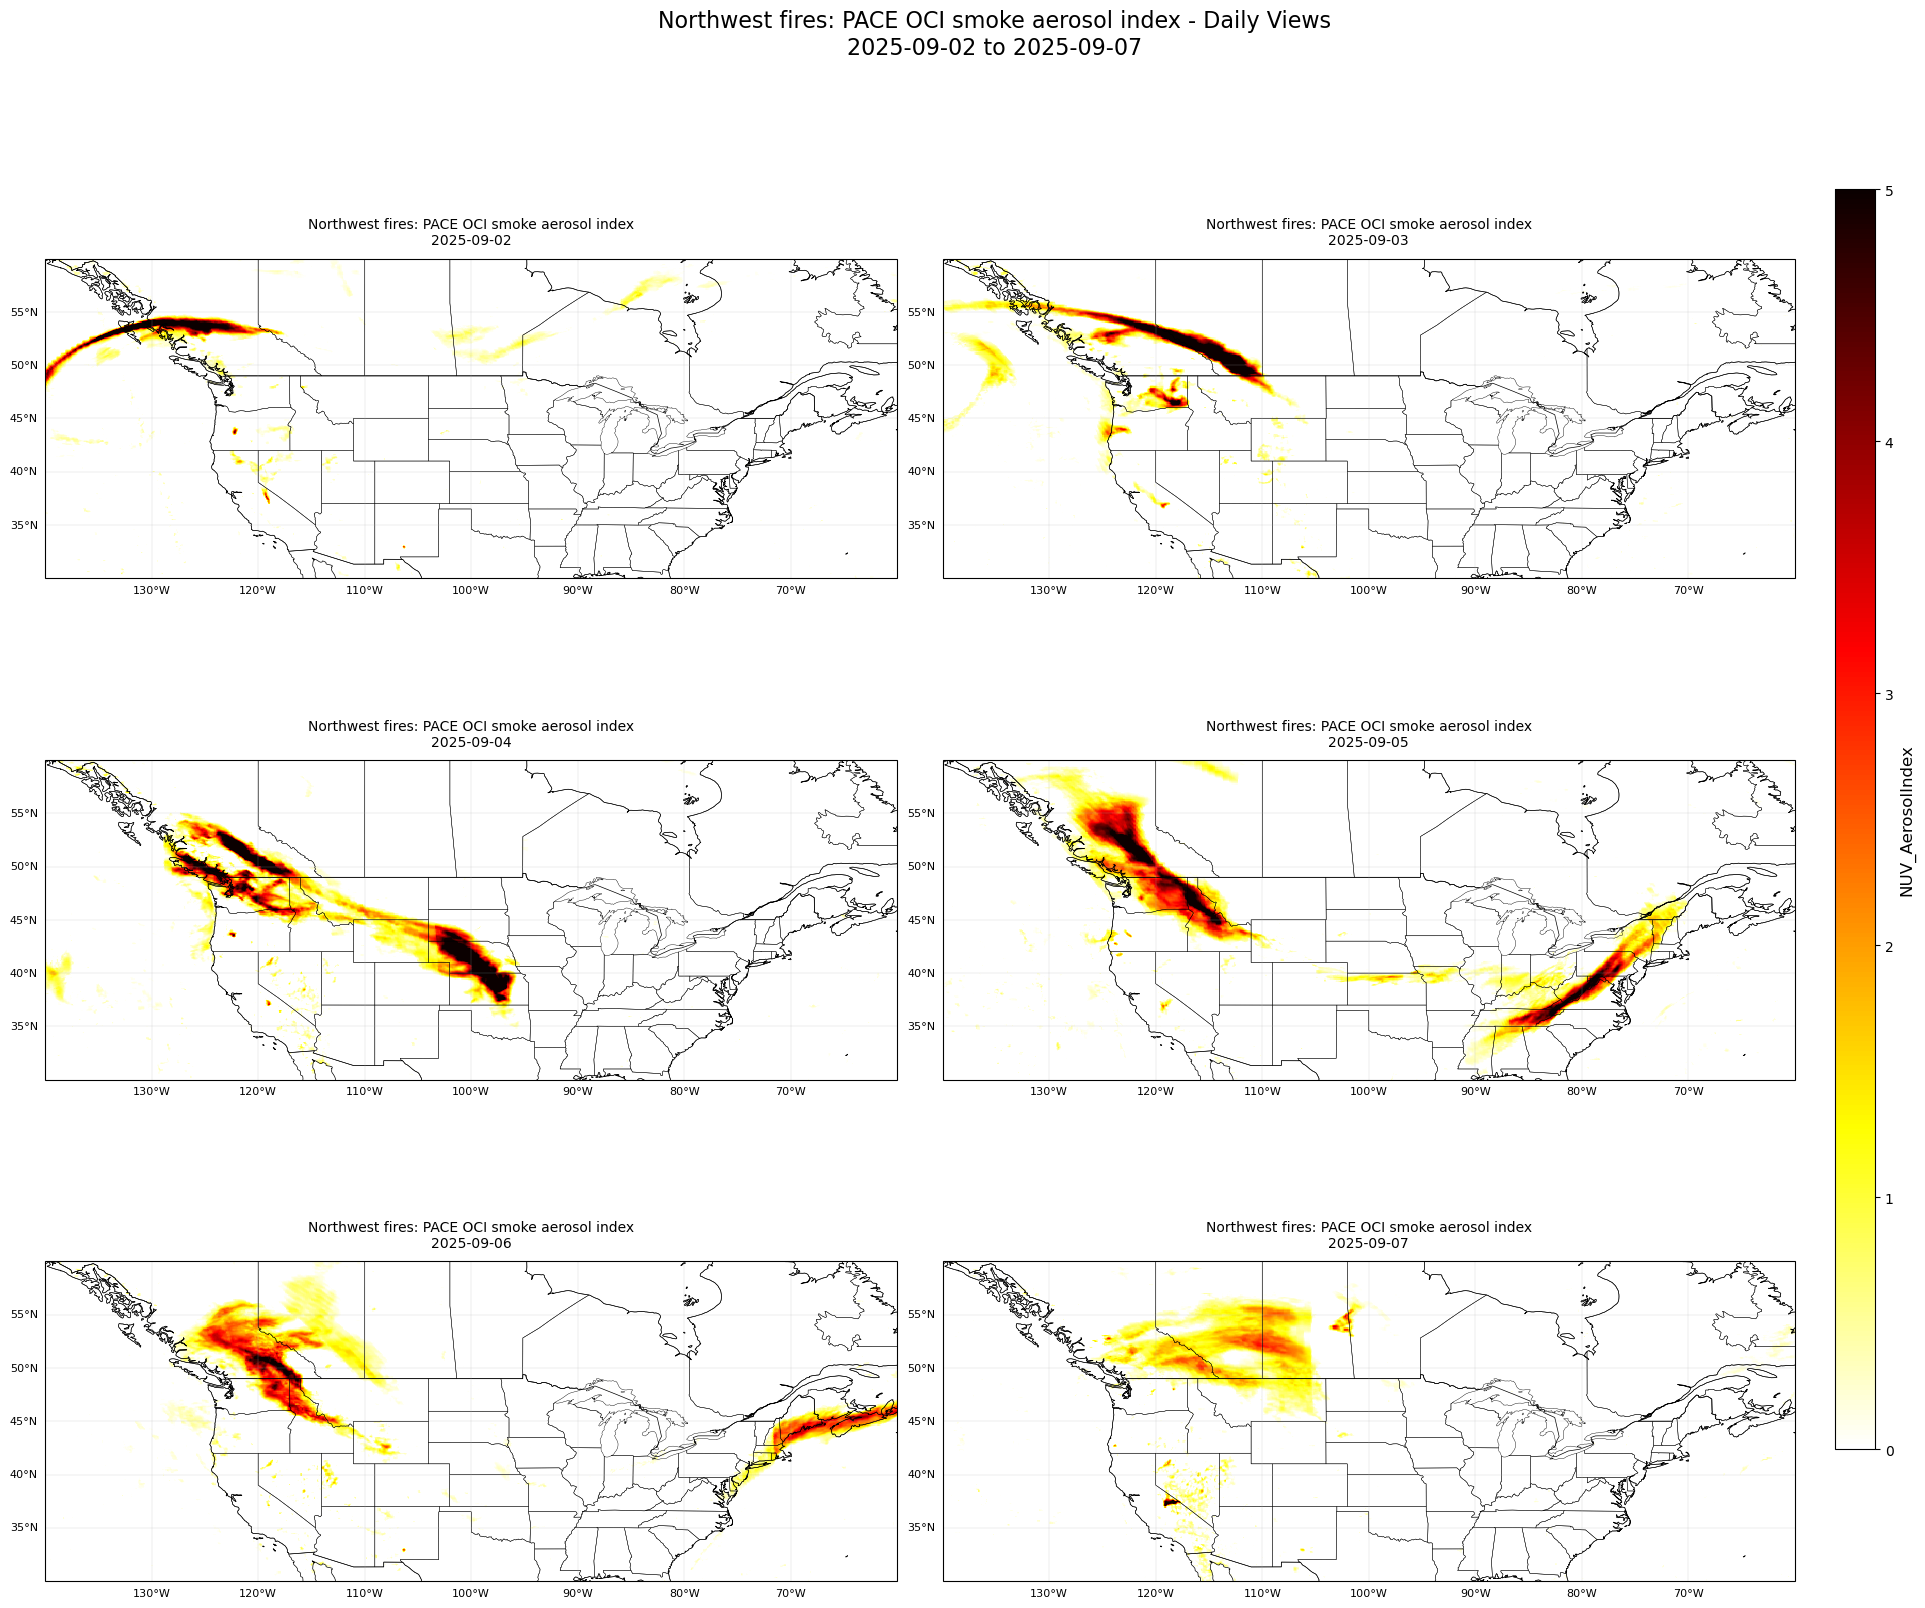

In [16]:
# Multi-day subplot plot (automatic grid)
fig, axes = plot_pace_l3_data_daily(
    dataset, 
    variable_name, 
    plot_range=plot_range,
    colormap=colormap,
    outdir=outdir,
    title_tag=TAG, 
    bbox=bbox,
    ncols=2,  
    figsize_per_plot=(10, 6),  # Larger subplots
)